# Packages

Top cell needed for installing umap in Colab

In [ ]:
!pip install umap-learn[plot]
!pip install holoviews
!pip install -U ipykernel

In [44]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA

import umap

import networkx as nx

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import matplotlib.colors as colors


from scipy.sparse import csr_matrix

# Data

We need:
- A VST/lognorm single cell expression matrix with rows=cells, columns=genes called `data`

In [55]:
pbmcVST = pd.read_csv('PBMCVST.tsv', sep='\t')
data = pbmcVST.T

Preprocessing of the data:
- Apply PCA and restrict to top 30 dimensions.
- For constructing a weighted graph on cells we use a 15-nearest neighbour graph with edge weights between 0 and 1 as given by the fuzzy simplicial set computed by UMAP.
- 'Adj' is the weighted adjacency matrix that will be used for the analysis.

In [47]:
data_np = data.to_numpy()
pca = PCA(30)
pca_data = pca.fit_transform(data_np)
reducer = umap.UMAP(metric="cosine", random_state=44, n_neighbors=15, min_dist=0.3)
emb_data = reducer.fit_transform(pca_data)

fuzzy_ss = umap.umap_.fuzzy_simplicial_set(pca_data, metric="cosine", random_state=44, n_neighbors=15)
Adj=csr_matrix.toarray(fuzzy_ss[0])

# Definitions and computation

In [48]:
def norm_lapl(adjacency, metric='euclidean'):
    """
    Creates a normalised Laplacian matrix given adjacency matrix.
    """
    degrees = adjacency.sum(axis=0)
    degree_matrix_inv_sqrt = np.diag(degrees ** -0.5)
    norm_lapl = np.eye(adjacency.shape[0]) - degree_matrix_inv_sqrt @ adjacency @ degree_matrix_inv_sqrt
    return norm_lapl

L = norm_lapl(Adj)
evalues, evectors = np.linalg.eigh(L)

degrees = Adj.sum(axis=0)
degree_matrix_sqrt = np.diag(degrees ** 0.5)

Df = degree_matrix_sqrt @ data
norms = np.linalg.norm(Df, axis=1).reshape((-1,1))
normed_genes = Df/norms


components = normed_genes.T @ evectors
compnp = components.to_numpy()
gene_names = components.index

comp_argsort = np.argsort(compnp, axis=0)
scores = np.sort(compnp, axis=0)[::-1, :]


In [49]:
e_scores_pos = gene_names[comp_argsort[::-1, :]]
e_scores_neg = gene_names[comp_argsort[:, :]]


eigenscore_genes = pd.DataFrame({'$eig_0^+$' : e_scores_pos[0:10,0],
                               '$eig_0^-$ ' : e_scores_neg[0:10,0],
                                 '$eig_1^+$' : e_scores_pos[0:10,1],
                               '$eig_1^-$ ' : e_scores_neg[0:10,1],
                                 '$eig_2^+$' : e_scores_pos[0:10,2],
                               '$eig_2^-$ ' : e_scores_neg[0:10,2],
                                 '$eig_3^+$' : e_scores_pos[0:10,3],
                               '$eig_3^-$ ' : e_scores_neg[0:10,3],
                                 '$eig_4^+$' : e_scores_pos[0:10,4],
                               '$eig_4^-$ ' : e_scores_neg[0:10,4],
                                 '$eig_5^+$' : e_scores_pos[0:10,5],
                               '$eig_5^-$ ' : e_scores_neg[0:10,5]})

<ipython-input-49-64d1ff5293c9>:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  e_scores_pos = gene_names[comp_argsort[::-1, :]]
<ipython-input-49-64d1ff5293c9>:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  e_scores_neg = gene_names[comp_argsort[:, :]]


Below we check how many eigenscores to take into account by setting the cut-off in eigenvalues to 0.1

In [50]:
sum(evalues < 0.1)

17

We restrict to a 17-dimensional eigenscore space below, which was the number given by the cut-off in the case of the PBMC data set.

In [51]:
comp17 = components.iloc[:, 1:17]
comp17_np = comp17.to_numpy()
distancematrix = squareform(pdist(comp17_np))


reducer = umap.UMAP(metric="precomputed", random_state=12, n_neighbors=15, min_dist=0.1)
emb = reducer.fit_transform(distancematrix)


genes = components.index
emb_df = pd.DataFrame(emb, index = genes)

def annotate_genes2(gene_list, coordinates, ax, x_index, y_index, x_offset, y_offset):
    for gene in gene_list:
        x_coord, y_coord = coordinates.loc[gene][[x_index, y_index]]
        ax.annotate(
            gene,
            xy=(x_coord, y_coord),
            xytext=(x_offset, y_offset),
            textcoords='offset points'
        )

def annotate_genes_dot(gene_list, coordinates, ax, x_index, y_index):
    for gene in gene_list:
        x_coord, y_coord = coordinates.loc[gene][[x_index, y_index]]
        ax.scatter(x_coord, y_coord, s=70, facecolors='none', edgecolors='k' )

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


# Example output

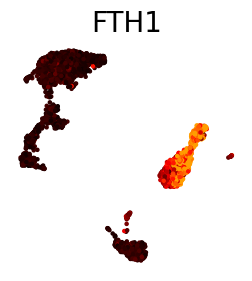

In [52]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('hot')
new_cmap = truncate_colormap(cmap, 0, 0.6)


fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(1,1,1)
ax.set_title('FTH1', fontsize = 20)
ax.scatter(emb_data[:,0],emb_data[:,1], s=5, cmap=new_cmap, c=data['FTH1'])
_ = ax.axis('off')

In [40]:
eigenscore_genes

,$eig_0^+$,$eig_0^-$,$eig_1^+$,$eig_1^-$,$eig_2^+$,$eig_2^-$,$eig_3^+$,$eig_3^-$,$eig_4^+$,$eig_4^-$,$eig_5^+$,$eig_5^-$
0,FTH1,RPS12,MALAT1,GPX1,FTH1,MALAT1,S100A4,CD74,GNLY,LTB,FCGR3A,S100A9
1,CD74,RPS6,RPS6,PPBP,S100A9,RPS27A,FTH1,HLA-DRA,FGFBP2,RPS12,LST1,FCER1A
2,HLA-DRA,RPS27,RPS27A,NRGN,S100A8,LTB,S100A9,HLA-DQA1,PRF1,RPS27,AIF1,S100A8
3,GNLY,RPS18,RPS3,PF4,LST1,RPS6,S100A8,HLA-DPB1,GZMA,RPS6,FCER1G,HLA-DPB1
4,FCER1G,RPS3A,RPS27,SDPR,AIF1,RPS27,TMSB4X,MS4A1,CTSW,RPS18,MS4A7,GPX1
5,S100A9,RPS3,RPS3A,SPARC,FCN1,RPS3A,CD3D,HLA-DQB1,SPON2,RPL11,FTH1,HLA-DQA1
6,PRF1,RPS27A,RPS12,GNG11,FCER1G,RPS3,S100A6,HLA-DRB1,FCGR3A,RPS3A,IFITM3,HLA-DRA
7,ACTB,RPL9,RPS18,GP9,S100A4,RPS12,AIF1,HLA-DPA1,CLIC3,RPL34,IFITM2,CD1C
8,FCGR3A,LTB,LTB,CLU,SAT1,CD3D,IL7R,HLA-DRB5,HOPX,RPL9,RHOC,GSTP1
9,HLA-DRB1,RPL11,RPL9,HIST1H2AC,HLA-DRA,RPL9,CD3E,HLA-DQA2,KLRD1,RPS3,SAT1,MS4A6A


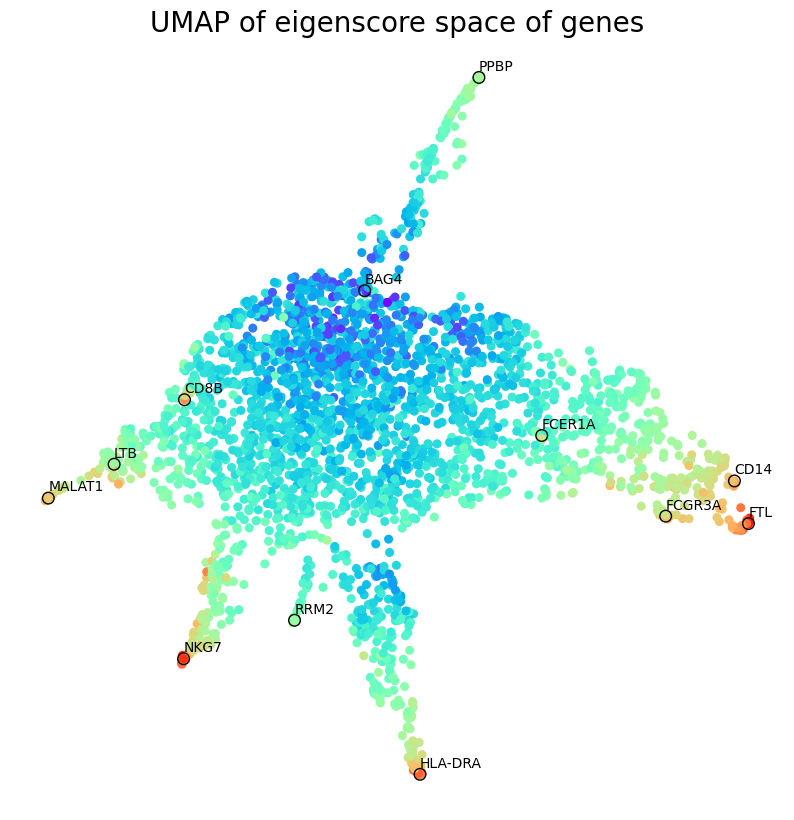

In [54]:
gene_list = ['NKG7', 'LTB', 'MALAT1',   'FCGR3A', 'HLA-DRA', 'FTL', 'PPBP', 'CD8B', 'RRM2', 'BAG4',
             'CD14', 'FCER1A']

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.set_title('UMAP of eigenscore space of genes', fontsize = 20)
ax.scatter(emb[:,0],emb[:,1], s=30, cmap='rainbow', c=np.log(np.linalg.norm(compnp[:,1:17], axis=1)))
_ = ax.axis('off')
annotate_genes2(gene_list, emb_df, ax, 0, 1, 0, 5)
annotate_genes_dot(gene_list, emb_df, ax, 0, 1)
#plt.savefig('PBMC_umap_eigenscores1-16.svg')